   The aim of this notebook is to work on the polarization of the cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
import seaborn as sns
import cv2 as cv

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale

from scipy.interpolate import splprep, splev

Error: IPOPT shared library failed to import


# Segmentation

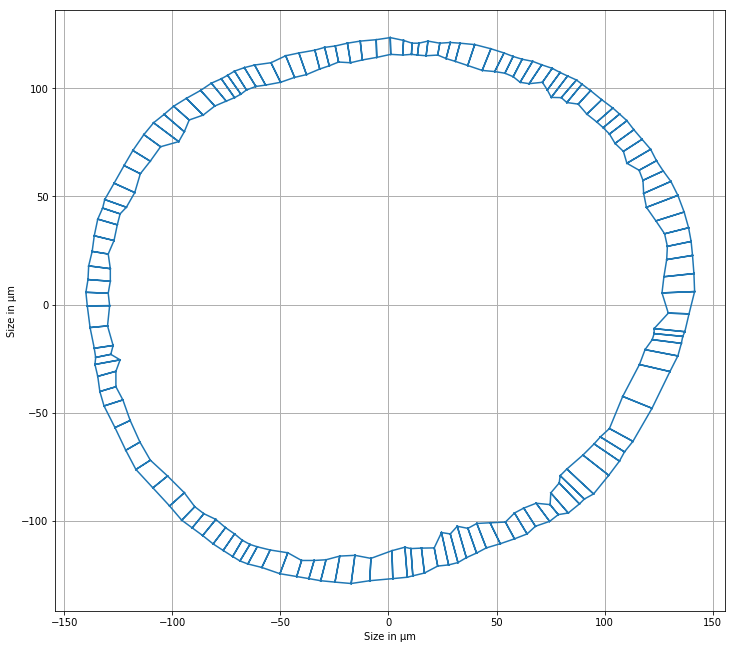

In [3]:
brigthfield_path = '../assets/sample_image_brightfield.tiff'
dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path, rol_window=1)



fig, ax = plt.subplots()
fig, ax = quick_edge_draw(organo, ax=ax)
plt.xlabel('Size in µm')
plt.ylabel('Size in µm')

fig.set_size_inches(12, 12)
ax.grid(linestyle='-', linewidth=1)

# Interpolation

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


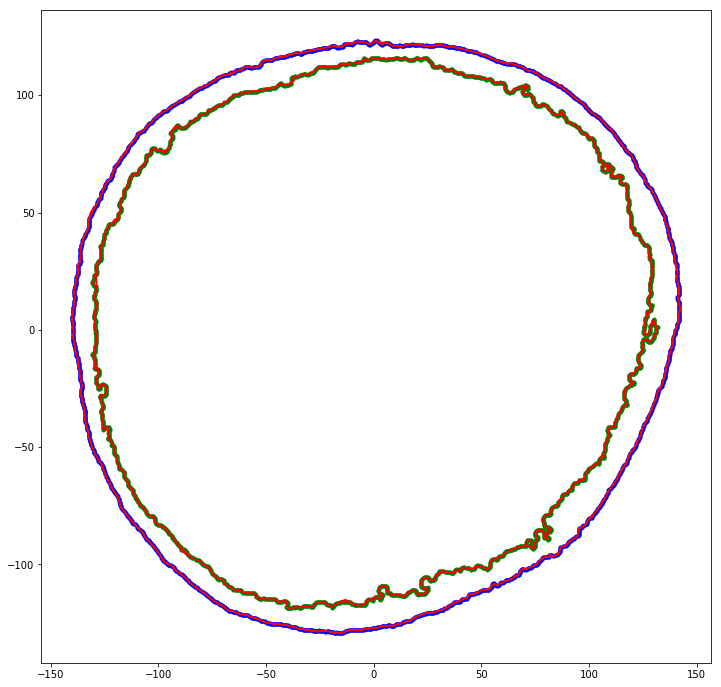

In [17]:
tck_inners, u_inners = splprep(inners.T, u=None, s=1e1, per=1) 
lins_inners = np.linspace(u_inners.min(), u_inners.max(), 1e3)
x_inners, y_inners = splev(lins_inners, tck_inners, der=0)

tck_outers, u_outers = splprep(outers.T, u=None, s=1e1, per=1) 
lins_outers = np.linspace(u_outers.min(), u_outers.max(), 1e3)
x_outers, y_outers = splev(lins_outers, tck_outers, der=0)

fig = plt.figure()
fig.set_size_inches(12, 12)
plt.plot(outers[:,0], outers[:,1], 'b.')
plt.plot(x_outers, y_outers, 'r-')
plt.plot(inners[:,0], inners[:,1], 'g.')
plt.plot(x_inners, y_inners, 'r-')
plt.show()

## Passing in polar coordinates

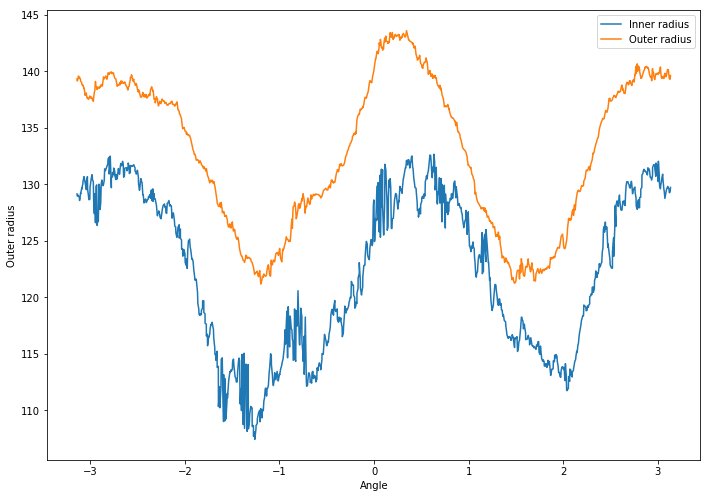

In [42]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

r_outers, p_outers = cart2pol(x_outers, y_outers)
r_inners, p_inners = cart2pol(x_inners, y_inners)

r_outers = r_outers[p_outers.argsort()]
r_inners = r_inners[p_inners.argsort()]

p_outers.sort()
p_inners.sort()

df = pd.DataFrame()
df['Angle'] = p_outers
df['Inner radius'] = r_inners
df['Outer radius'] = r_outers

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.lineplot(x="Angle", y="Inner radius", ax=ax,
             data=df, label='Inner radius')
sns.lineplot(x="Angle", y="Outer radius", ax=ax,
             data=df, label='Outer radius')



Computing the difference between the two splines

In [45]:
diff = r_outers - r_inners
df['Difference'] = diff

Plotting the rolling mean of the difference for readable reasults

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


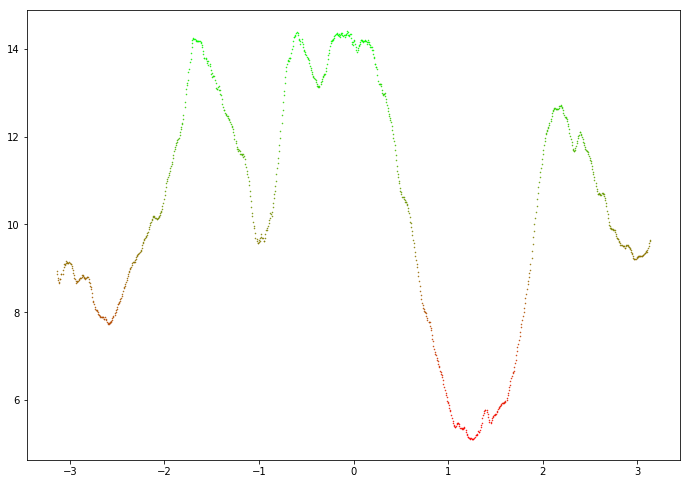

In [82]:
rolling_mean = df['Difference'].rolling(50, min_periods=1, center=True).mean()
df['Rolling average'] = rolling_mean

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(11.7, 8.27)

span_length = 1e3
y_span = np.linspace(df['Rolling average'].min(), df['Rolling average'].max(), span_length)
y_color_table = np.zeros(df['Rolling average'].shape)
for (ind, point) in enumerate(df['Rolling average']):
    box = 0
    while point>y_span[box]:
        box+=1
    y_color_table[ind] = box
    ax.plot(df['Angle'][ind],df['Rolling average'][ind],'.',markersize=1, color=((span_length-box)/span_length,
                                                                                 box/span_length,
                                                                                 0))

Put it back to cartesian coordinates

1000 1000


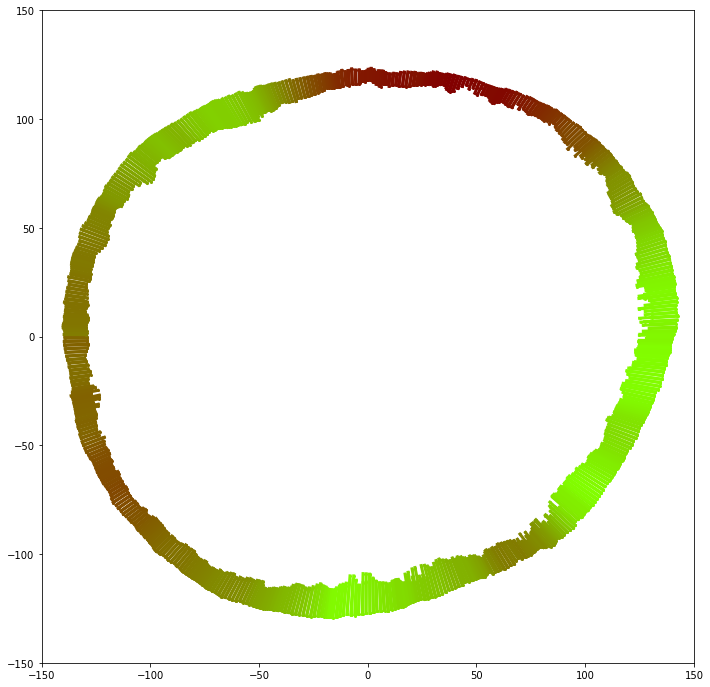

In [84]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

x_outers, y_outers = pol2cart(df['Outer radius'], df['Angle'])
x_inners, y_inners = pol2cart(df['Inner radius'], df['Angle'])

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(12, 12)
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.gca().set_aspect('equal', adjustable='box')
print(len(x_inners), len(x_outers))

for (ind, point) in enumerate(y_inners):
    ax.plot(x_inners[ind], y_inners[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
    ax.plot(x_outers[ind], y_outers[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
    plt.plot([x_inners[ind], x_outers[ind]], [y_inners[ind], y_outers[ind]],
             marker='o',
             markersize=2,
             linewidth=3,
             color=((span_length-box)/span_length, y_color_table[ind]/span_length, 0))



In [93]:
[(cos(x / 10.), x / 10.) for x in range(-50, 50, 5)]

[(0.28366218546322625, -5.0),
 (-0.2107957994307797, -4.5),
 (-0.6536436208636119, -4.0),
 (-0.9364566872907963, -3.5),
 (-0.9899924966004454, -3.0),
 (-0.8011436155469337, -2.5),
 (-0.4161468365471424, -2.0),
 (0.0707372016677029, -1.5),
 (0.5403023058681398, -1.0),
 (0.8775825618903728, -0.5),
 (1.0, 0.0),
 (0.8775825618903728, 0.5),
 (0.5403023058681398, 1.0),
 (0.0707372016677029, 1.5),
 (-0.4161468365471424, 2.0),
 (-0.8011436155469337, 2.5),
 (-0.9899924966004454, 3.0),
 (-0.9364566872907963, 3.5),
 (-0.6536436208636119, 4.0),
 (-0.2107957994307797, 4.5)]

In [96]:
import pygal
from pygal.style import DefaultStyle 

from math import cos
xy_chart = pygal.XY(show_legend=False, show_dots=False)
xy_chart.title = 'XY Cosinus'
for (ind, point) in enumerate(y_inners):
    xy_chart.add('x = '+str(ind), [(y_inners[ind], x_inners[ind]), (y_outers[ind], x_outers[ind])])
xy_chart.render_to_file('/home/fquinton/Bureau/scatter_chart.svg')  

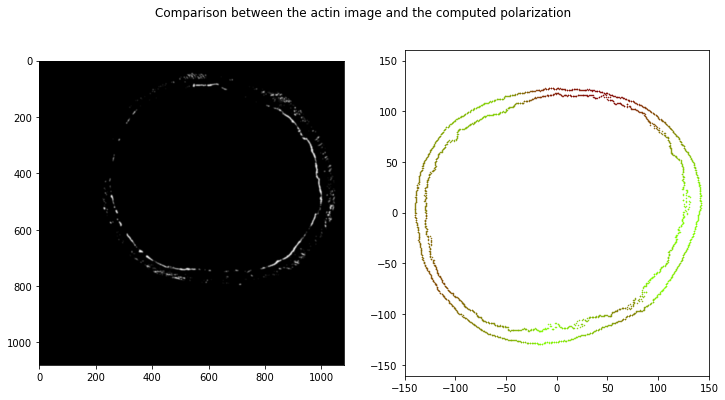

In [97]:
path = '../assets/sample_image_actin.tiff'

img = cv.imread(path,cv.IMREAD_GRAYSCALE)

copy = img.copy()
ret,copy = cv.threshold(copy,1,255,0)

f, (ax1, ax2) = plt.subplots(1, 2)
f.suptitle('Comparison between the actin image and the computed polarization')
f.set_size_inches(12, 6)
ax1.imshow(copy, cmap = 'gray', interpolation = 'bicubic')
plt.xlim(-150, 150)
plt.ylim(-110, 110)
plt.gca().set_aspect('equal', adjustable='datalim')
for (ind, point) in enumerate(y_inners):
    ax2.plot(x_inners[ind], y_inners[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))

for (ind, point) in enumerate(y_inners):
    ax2.plot(x_outers[ind], y_outers[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
